In [1]:
import os 
import h5py
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

In [3]:
# read in SDSS measurements 
fsdss = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.valueadd.hdf5') 
sdss = h5py.File(fsdss, 'r') 

mr_complete = (sdss['mr_tinker'][...] < -20.) 
F_mag_sdss = sdss['ABSMAG'][...][:,0][mr_complete]
N_mag_sdss = sdss['ABSMAG'][...][:,1][mr_complete]
R_mag_sdss = sdss['mr_tinker'][...][mr_complete] #sdss['ABSMAG'][...][:,4]
FUV_NUV_sdss = F_mag_sdss - N_mag_sdss

Haflux_sdss = sdss['HAFLUX'][...][mr_complete]
Hbflux_sdss = sdss['HBFLUX'][...][mr_complete]
balmer_ratio_sdss = Haflux_sdss/Hbflux_sdss 

# read in SDSS LF 
fphi = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.phi_Mr.dat') 
mr_low, mr_high, phi_sdss, phi_sdss_err = np.loadtxt(fphi, unpack=True, usecols=[0,1,2,3]) 

In [8]:
def sim_observables(sim): 
    '''
    '''
    # read simulations 
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
    downsample = np.zeros(len(_sim_sed['logmstar'])).astype(bool)
    downsample[::10] = True
    f_downsample = 0.1
    
    cens = _sim_sed['censat'].astype(bool) & (_sim_sed['logmstar'] > 9.4) & downsample

    sim_sed = {} 
    sim_sed['sim']          = sim
    sim_sed['logmstar']     = _sim_sed['logmstar'][cens].copy()
    sim_sed['logsfr.100']   = _sim_sed['logsfr.100'][cens].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed']    = _sim_sed['sed_neb'][cens,:][:,wlim].copy() 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sim_sed['sed'], band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sim_sed['sed'], band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sim_sed['sed'], band='r_sdss') 
    FUV_NUV = F_mag - N_mag 
    
    # balmer measurements 
    Ha_dust, Hb_dust = measureObs.L_em(['halpha', 'hbeta'], sim_sed['wave'], sim_sed['sed']) 
    balmer_ratio = Ha_dust/Hb_dust
    
    # get luminosity function 
    mr_mid, phi_sim = measureObs.LumFunc(R_mag, name=sim_sed['sim'], mr_bin=None)
    phi_sim /= f_downsample # in case you downsample 
    
    return R_mag, FUV_NUV, balmer_ratio, mr_mid, phi_sim

In [9]:
R_mag_simba, FUV_NUV_simba, balmer_ratio_simba, mr_mid, phi_simba = sim_observables('simba')

In [11]:
HaHb_I = 2.86 # intrinsic balmer ratio 

In [15]:
R_mag_tng, FUV_NUV_tng, balmer_ratio_tng, _, phi_tng = sim_observables('tng')

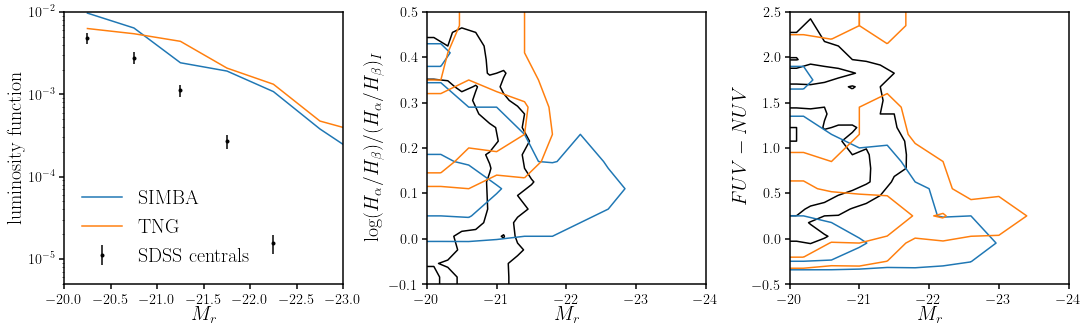

In [22]:
fig = plt.figure(figsize=(18,5))
# luminosity function 
sub = fig.add_subplot(131)
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err,
        fmt='.k', label='SDSS centrals')
sub.plot(mr_mid, phi_simba, c='C0', label='SIMBA')
sub.plot(mr_mid, phi_tng, c='C1', label='TNG')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(-20, -23) 
sub.set_ylabel('luminosity function', fontsize=20)
sub.set_yscale('log') 
sub.set_ylim(5e-6, 1e-2) 
sub.legend(loc='lower left', fontsize=20)

# Mr - Balmer ratio
sub = fig.add_subplot(132)
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
DFM.hist2d(R_mag_simba, np.log10(balmer_ratio_simba/HaHb_I), color='C0', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)
DFM.hist2d(R_mag_tng, np.log10(balmer_ratio_tng/HaHb_I), color='C1', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(-20, -24) 
sub.set_ylabel(r'$\log (H_\alpha/H_\beta)/(H_\alpha/H_\beta)_I$', fontsize=20) 
sub.set_ylim(-0.1, 0.5) 

# Mr - A_FUV
sub = fig.add_subplot(133)
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
DFM.hist2d(R_mag_simba, FUV_NUV_simba, color='C0', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
DFM.hist2d(R_mag_tng, FUV_NUV_tng, color='C1', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(-20, -24) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(-0.5, 2.5) 
fig.subplots_adjust(wspace=0.3)